# Neural Networks with PyTorch

In [1]:
# torch imports 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(42)

# numpy / matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### Plotting functionality for later

In [2]:
def plot_XOR_network(network, two_outputs=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax2 = fig.add_subplot(122, projection='3d')

    delta = 0.01
    xmin=-0.1;xmax=1.1;ymin=-0.1;ymax=1.1
    xs = np.arange(xmin, xmax, delta)
    ys = np.arange(ymin, ymax, delta)
    x_grid, y_grid = np.meshgrid(xs, ys)

    xs = x_grid.reshape(-1)
    ys = y_grid.reshape(-1)
    x = np.vstack((xs, ys))
    x_tensor = torch.tensor(x.T, dtype=torch.float32, 
                            requires_grad=False, device=device)
    Z = model(x_tensor).detach().cpu().numpy()
    if two_outputs :
        Z = Z[:, 1] - Z[:, 0]
    Z = Z.reshape(x_grid.shape)

    if two_outputs:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=-1, vmax=1)
    else:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=0, vmax=1)

    X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
    y = np.array([0, 1, 1, 0])

    plt.style.use('default')
    ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='bwr', edgecolors='w');
    ax.plot([], [], 'or', label='1')
    ax.plot([], [], 'ob', label='0')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()


In [3]:
def plot_circles_network(network, two_outputs=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax2 = fig.add_subplot(122, projection='3d')
    
    r1 = 0.5
    r2 = np.sqrt(2*r1**2)
    r3 = np.sqrt(r1**2 + r2**2)

    delta = 0.01
    xmin=-1.1;xmax=1.1;ymin=-1.1;ymax=1.1
    xs = np.arange(xmin, xmax, delta)
    ys = np.arange(ymin, ymax, delta)
    x_grid, y_grid = np.meshgrid(xs, ys)

    xs = x_grid.reshape(-1)
    ys = y_grid.reshape(-1)
    x = np.vstack((xs, ys))
    x_tensor = torch.tensor(x.T, dtype=torch.float32, 
                            requires_grad=False, device=device)
    Z = model(x_tensor).detach().cpu().numpy()
    
    if two_outputs :
        Z = Z[:, 1] - Z[:, 0]
    Z = Z.reshape(x_grid.shape)

    if two_outputs:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=-0.001, vmax=0.001)
    else:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=0, vmax=1)

    plt.style.use('default')
    #ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='bwr', edgecolors='w');
    ax.plot([], [], 'or', label='1')
    ax.plot([], [], 'ob', label='0')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    
    circle = plt.Circle((0, 0), r1, alpha=0.5, edgecolor='k')
    annulus = matplotlib.patches.Wedge((0, 0), r3, 0, 360, width=r3-r2, facecolor='r', alpha=0.5, edgecolor='k')
    ax.add_artist(circle)
    ax.add_artist(annulus)


## Introduction to PyTorch

Last time we introduced neural networks and built a simple architecture we could use to (sometimes) solve the XOR problem.  We saw the challenge of programming a network with increasing numbers of units and layers, related to computing the derivative of the loss function.

Fortunately, there exist a number of packages designed for neural networks that automatically compute the gradient using backpropagation.  A few of the packages that are used in CSU's CS department are [PyTorch](https://pytorch.org), [TensorFlow](https://www.tensorflow.org),  and [Keras](https://keras.io).  These packages use Python despite the fact that Python may be relatively slow compared to compiled languages.  These deep learning packages often compile their code into those faster languages or are able to take advantage of optimizations that give competitive performance.

We'll use PyTorch as it is simple to use and competitive with other options.

First, we will create our dataset - the same XOR problem discussed in the previous notebook.  The only difference is that we convert the input values to be 32 bit floating point values, rather than 64 bit.  This isn't strictly necessary, but most neural network packages use 32 bit floats because the added precision is not worth the memory and computational cost.

In [4]:
# if you have a GPU we should enable it
# mps is the pytorch device that supports GPU computations on MacOS

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
device = "cpu"

In [6]:
X_xor = torch.tensor([[0,0],[0,1], [1,0], [1,1]], 
                     dtype=torch.float32, 
                     requires_grad=False, 
                     device=device)
Y_xor = torch.tensor([0,1,1,0], 
                     dtype=torch.float32, 
                     requires_grad=False,
                     device=device).view(-1,1)
# view is the same as the NumPy reshape function

In [7]:
X_xor

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

In [8]:
Y_xor

tensor([[0.],
        [1.],
        [1.],
        [0.]])

Now are now ready to create the network using the PyTorch [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) interface.

In [10]:
input_dim = 2
hidden_dim = 10
output_dim = 1
model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim),
                      )
model = model.to(device)

This sets up a network that looks like this:

<img style="padding:10px;width:80%;" alt="Simple multilayer perceptron architecture" src="https://github.com/asabenhur/CS345/raw/master/fall20/notebooks/figures/single_hidden_10_node.png">

The first layer  in the network is our hidden layer.  Having two nodes would give us a network which *can* work, but frequently doesn't, so let's create a much larger network with ten nodes in its hidden layer.  This is referred to as a ```Dense``` layer, as every input has a weight connecting it to every node in the previous layer.  We also tell PyTorch to use the ReLU activation function for it.

In [11]:
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [12]:
model[0]

Linear(in_features=2, out_features=10, bias=True)

The network parameters have been initialized:

In [13]:
model[0].weight

Parameter containing:
tensor([[-0.1918,  0.2976],
        [ 0.6313,  0.4087],
        [-0.3091,  0.4082],
        [ 0.1265,  0.3591],
        [-0.4310, -0.7000],
        [-0.2732, -0.5424],
        [ 0.5802,  0.2037],
        [ 0.2929,  0.2236],
        [-0.0123,  0.5534],
        [-0.5024,  0.0445]], requires_grad=True)

In [14]:
model[0].bias

Parameter containing:
tensor([-0.4826,  0.2180, -0.2435,  0.2167, -0.1473,  0.5865, -0.4191, -0.4217,
        -0.4217,  0.6360], requires_grad=True)

To produce an output we simply call the model's forward function:

In [15]:
y_hat = model.forward(X_xor)
y_hat

tensor([[-0.4458],
        [-0.3343],
        [-0.1326],
        [ 0.0067]], grad_fn=<AddmmBackward0>)

This can be abbreviated as:

In [16]:
model(X_xor)

tensor([[-0.4458],
        [-0.3343],
        [-0.1326],
        [ 0.0067]], grad_fn=<AddmmBackward0>)

Let us set up the loss function and compute it:

In [17]:
loss_func = nn.MSELoss()
y_hat = model(X_xor)

loss = loss_func(y_hat, Y_xor)
loss

tensor(0.8155, grad_fn=<MseLossBackward0>)

In order to optimize the network we need to compute the gradient of the loss function.  PyTorch makes that easy!  Every parameter has a `grad` attribute that accumulates its gradient:

In [18]:
loss = loss_func(y_hat, Y_xor)

model.zero_grad()     # zeroes the gradient of all parameters

print('model[0].bias.grad before backward')
print(model[0].bias.grad)

loss.backward()

print('model[0].bias.grad after backward')
print(model[0].bias.grad)

model[0].bias.grad before backward
None
model[0].bias.grad after backward
tensor([ 0.0000e+00, -4.4214e-01,  1.7412e-01,  4.5575e-01,  0.0000e+00,
         3.0980e-01, -7.2104e-02,  3.7965e-04, -1.7443e-01,  2.3729e-01])


We are now ready to set up the training process.  
We will use the mean squared error as the loss function and use stochastic gradient descent as the optimizer:

In [22]:
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)#, momentum=0.9)

def train(epochs=50) :
    # if you would like to use tensorboard:
    #from torch.utils.tensorboard import SummaryWriter
    #writer = SummaryWriter()
    loss_values = []
    steps_per_epoch = X_xor.size(0)
    for epoch in range(epochs):
        for j in range(steps_per_epoch):
            data_point = np.random.randint(X_xor.size(0))
            x_var = Variable(X_xor[data_point], requires_grad=False)
            y_var = Variable(Y_xor[data_point], requires_grad=False)
            optimizer.zero_grad()
            y_hat = model(x_var)
            loss = loss_func.forward(y_hat, y_var)
            #writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
        loss_values.append(loss.data.cpu().numpy())
        if epoch % 10 == 0 :
            print("epochs: " + str(epoch) + "\tloss: " + str(loss.data.cpu().numpy()))
    return loss_values

epochs: 0	loss: 6.963319e-11
epochs: 10	loss: 1.5967316e-10
epochs: 20	loss: 4.456524e-11
epochs: 30	loss: 7.517542e-12
epochs: 40	loss: 1.4210855e-12
epochs: 50	loss: 2.0520474e-11
epochs: 60	loss: 1.7195134e-12
epochs: 70	loss: 5.684342e-14
epochs: 80	loss: 1.4210855e-12
epochs: 90	loss: 2.2737368e-13


Text(0.5, 0, 'epoch')

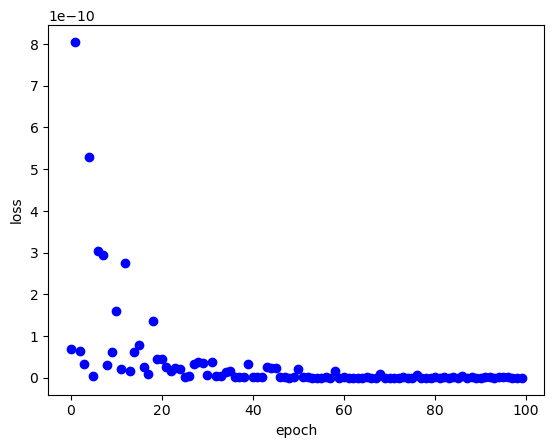

In [23]:
loss_values = train(epochs=100)
plt.plot(loss_values, 'ob')
plt.ylabel('loss')
plt.xlabel('epoch')

In [24]:
# evalue the model
model(X_xor)

tensor([[-7.1526e-07],
        [ 1.0000e+00],
        [ 1.0000e+00],
        [-7.1526e-07]], grad_fn=<AddmmBackward0>)

Let's do the same using a PyTorch class:

In [25]:
class XOR_network(nn.Module):
    """
    Solve the XOR problem with a neural network with one hidden layer
    """
    def __init__(self, input_dim = 2, hidden_dim=10, output_dim=1):
        super(XOR_network, self).__init__()
        # create two linear layers 
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.linear2 = nn.Linear(hidden_dim, output_dim, bias=True)
    
    def forward(self, x):
        """The forward pass of the network
        arguments:
            x (torch.Tensor): an input data tensor
        returns:
            the network output (torch.Tensor)
        """
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


**Notes:**

* `nn.Module` is the base class for neural networks in PyTorch.  Your models should subclass this class.
* Every network should implement a `forward` function which computes the output of the network.

In [26]:
# create an instance of the network:
model = XOR_network()
model.to(device)

XOR_network(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
model.linear1

Linear(in_features=2, out_features=10, bias=True)

In [24]:
model.linear1.weight

Parameter containing:
tensor([[-0.1918,  0.2976],
        [ 0.6313,  0.4087],
        [-0.3091,  0.4082],
        [ 0.1265,  0.3591],
        [-0.4310, -0.7000],
        [-0.2732, -0.5424],
        [ 0.5802,  0.2037],
        [ 0.2929,  0.2236],
        [-0.0123,  0.5534],
        [-0.5024,  0.0445]], requires_grad=True)

In [25]:
model.linear1.bias

Parameter containing:
tensor([-0.4826,  0.2180, -0.2435,  0.2167, -0.1473,  0.5865, -0.4191, -0.4217,
        -0.4217,  0.6360], requires_grad=True)

epochs: 0	loss: 0.00018018001
epochs: 10	loss: 0.032944746
epochs: 20	loss: 0.003349106
epochs: 30	loss: 0.0032820983
epochs: 40	loss: 0.0005013445
epochs: 50	loss: 3.9996585e-06
epochs: 60	loss: 1.1703438e-08
epochs: 70	loss: 4.863665e-10
epochs: 80	loss: 1.6427748e-11
epochs: 90	loss: 7.993606e-11


Text(0.5, 0, 'epoch')

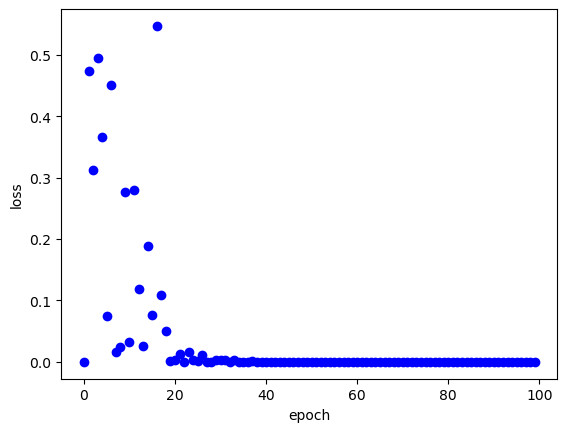

In [22]:
model = XOR_network()
model.to(device)

loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

loss_values = train(epochs=100)
plt.plot(loss_values, 'ob')
plt.ylabel('loss')
plt.xlabel('epoch')

We can now compute predictions using the model:

In [23]:
model(X_xor[0]).detach().cpu().numpy()[0]
# detach: detaches a tensor from its computational graph

-8.34465e-07

In [24]:
model(X_xor).detach().cpu().numpy()

array([[-8.3446503e-07],
       [ 9.9999863e-01],
       [ 9.9999732e-01],
       [-2.9206276e-06]], dtype=float32)

Remember that the network is trying to approximate the values [0, 1, 1, 0].

Let's compute the decision surface of this network:

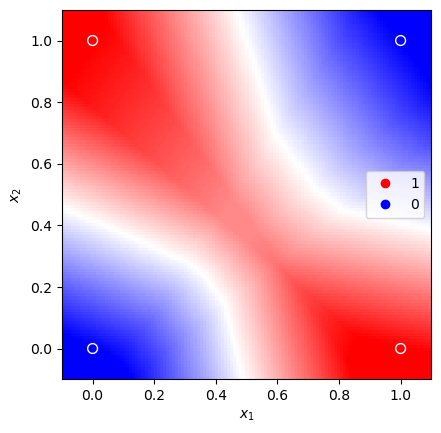

In [25]:
plot_XOR_network(model)

We can also add more layers and have more nodes in each layer.

#### Exercise

Create a network with two hidden layers for the XOR problem.

## Loss functions and the softmax function

The squared error loss isn't the best loss function to be using: it is designed for regression problems. Instead, will use the **cross entropy** loss function.  To do this, we will need to change our expected outputs from being 0 or 1 to be "one-hot-encoded:"

In [58]:
Y_xor_int = torch.tensor([0,1,1,0], 
                         dtype=torch.int64, 
                         requires_grad=False,
                         device=device)

Y_xor_one_hot = F.one_hot(Y_xor_int)
# alternatively:  
# Y_xor_one_hot = F.one_hot(Y_xor_int, 2)
print(Y_xor_one_hot)

tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0]])


In [59]:
# one_hot returns an integer tensor
# need to convert it to a floating point tensor:
Y_xor_one_hot = Y_xor_one_hot.type(torch.FloatTensor)
print(Y_xor_one_hot.dtype)

torch.float32


In the network below we use the **binary cross entropy** loss function  which uses a softmax activation on the output.

Binary cross entropy is defined as follows:

$$
\mathcal{l}^{CE}(\hat{y}, y) = - y \log \hat{y} - (1-y) \log (1 - \hat{y})
$$

It quantifies the discrepancy of the predicted probability from the desired label.  To demonstrate that it indeed functions like a loss function, let's plot this function for $y = 1$ and $y=0$:

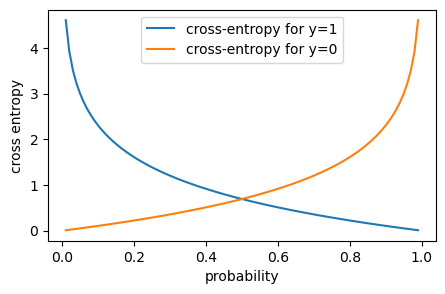

In [60]:
def cross_entropy(p, y):
    return -(y*np.log(p)+(1-y)*np.log(1-p))

plt.figure(figsize=(5,3))
p = np.linspace(0.01, 0.99, 100)
plt.plot(p, cross_entropy(p, 1), label='cross-entropy for y=1')
plt.plot(p, cross_entropy(p, 0), label='cross-entropy for y=0')

plt.xlabel('probability')
plt.ylabel('cross entropy')
plt.legend();

In [73]:
input_dim = 2
hidden_dim = 10
output_dim = 2
model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim),
                      nn.Sigmoid()
                      )
model = model.to(device)

loss_func = torch.nn.BCELoss()
#loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

In [62]:
def train(epochs=50) :
    # if you would like to use tensorboard:
    #from torch.utils.tensorboard import SummaryWriter
    #writer = SummaryWriter()
    loss_values = []
    steps_per_epoch = X_xor.size(0)
    for epoch in range(epochs):
        for j in range(steps_per_epoch):
            data_point = np.random.randint(X_xor.size(0))
            x_var = Variable(X_xor[data_point], requires_grad=False)
            y_var = Variable(Y_xor_one_hot[data_point], requires_grad=False)
            optimizer.zero_grad()
            y_hat = model(x_var)
            loss = loss_func.forward(y_hat, y_var)
            #writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
        loss_values.append(loss.data.cpu().numpy())
        if epoch % 10 == 0 :
            print("epochs: " + str(epoch) + "\tloss: " + str(loss.data.cpu().numpy()))
    return loss_values

In [66]:
y_var = Variable(Y_xor_one_hot[0], requires_grad=False)
x_var = Variable(X_xor[0], requires_grad=False)
y_hat = model(x_var)
y_hat

tensor([0.9729, 0.0287], grad_fn=<SigmoidBackward0>)

epochs: 0	loss: 0.086228065
epochs: 10	loss: 0.20045578
epochs: 20	loss: 0.037518397
epochs: 30	loss: 0.17313886
epochs: 40	loss: 0.11651082
epochs: 50	loss: 0.04199878
epochs: 60	loss: 0.049174152
epochs: 70	loss: 0.092409596
epochs: 80	loss: 0.07296519
epochs: 90	loss: 0.070406675
epochs: 100	loss: 0.025608517
epochs: 110	loss: 0.064403065
epochs: 120	loss: 0.023087818
epochs: 130	loss: 0.047940746
epochs: 140	loss: 0.023818512
epochs: 150	loss: 0.019574359
epochs: 160	loss: 0.032630574
epochs: 170	loss: 0.020919144
epochs: 180	loss: 0.017727993
epochs: 190	loss: 0.014157259
epochs: 200	loss: 0.013124718
epochs: 210	loss: 0.012802912
epochs: 220	loss: 0.014760107
epochs: 230	loss: 0.026646025
epochs: 240	loss: 0.014120151
epochs: 250	loss: 0.024079956
epochs: 260	loss: 0.010101112
epochs: 270	loss: 0.01234811
epochs: 280	loss: 0.009684698
epochs: 290	loss: 0.012197178
epochs: 300	loss: 0.00956241
epochs: 310	loss: 0.01825602
epochs: 320	loss: 0.016378254
epochs: 330	loss: 0.015350573

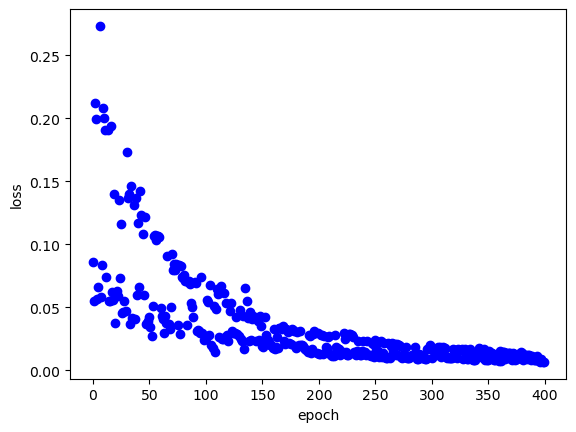

In [75]:
loss_values = train(epochs=400)
plt.plot(loss_values, 'ob')
plt.ylabel('loss')
plt.xlabel('epoch');

To visualize the decision surface, we will plot $z_1 - z_2$.  This is a trick we will use throughout the rest of the notebook.

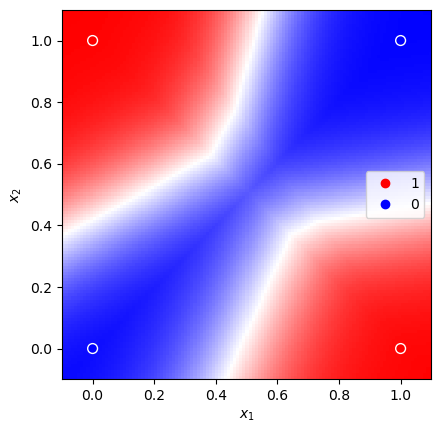

In [65]:
plot_XOR_network(model, two_outputs=True)

## Nonconvex Optimization

For linear models, finding a solution that minimizes some quantity of interest was relatively easy because the error surface has a single global minimum.  Whenever the error function satisfies a certain condition known as "convexity", this is guaranteed to be the case.
Here's an example of a loss surface of a convex problem:

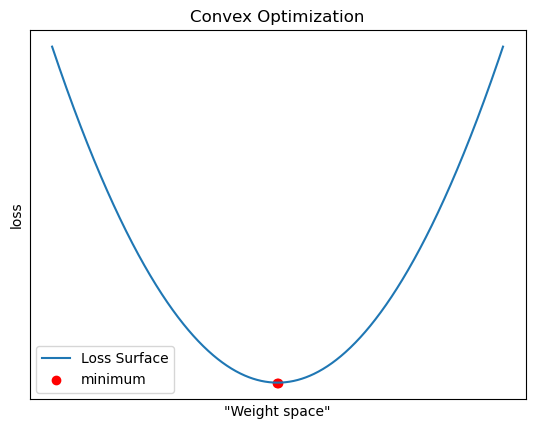

In [40]:
x = np.linspace(-10, 10, 1000)
y = np.power(x, 2)
points = np.r_[True, y[1:] <= y[:-1]] & np.r_[y[:-1] <= y[1:], True]
plt.plot(x, y, label='Loss Surface')
plt.xlabel('"Weight space"')
plt.ylabel('loss')
plt.title("Convex Optimization")
plt.xticks([])
plt.yticks([])
plt.scatter(x[points], y[points], c='r', label='minimum')
plt.legend();

As we change the weights of the model, we move around on the blue curve.  The goal is to find a configuration of weights that places us at the location of the red dot, which is the minimum of this function.

However, due to the nonlinearity of neural networks, there may be more than one minimum.  For example:

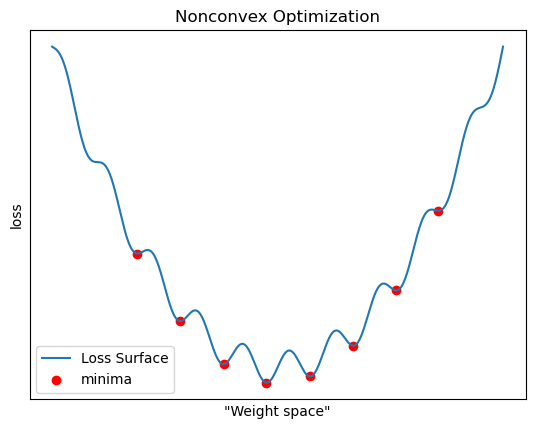

In [41]:
x = np.linspace(-10, 10, 1000)
y = np.power(x, 2) + 5*np.sin(np.pi*x)
points = np.r_[True, y[1:] < y[:-1]] & np.r_[y[:-1] < y[1:], True]
plt.plot(x, y, label="Loss Surface")
plt.xlabel('"Weight space"')
plt.ylabel('loss')
plt.xticks([])
plt.yticks([])
plt.title("Nonconvex Optimization")
plt.scatter(x[points], y[points], c='r', label='minima')
plt.legend();

In this case, there is a single global minimum that represents the optimal solution, but there are a number of other *local* minima.

Gradient descent and many of its variants are the most commonly used algorithms for optimizing the weights of neural networks.  Gradient descent can be thought of as behaving like a ball that is placed on the the loss surface - it rolls down hills.  That means that if an initial configuration of a neural network lies somewhere in a valley around one of the local minima, gradient descent will push it towards that local minimum rather than the global minimum.
However, that may or may not be a problem!  We are interested in solutions that have high prediction accuracy - not necessarily finding the global minimum.


## Gradient Descent Modifications and Regularization

The simple SGD algorithm has a modification that can help with shallow local minima and plateaus in the loss surface - momentum.  Intuitively, this is the same as the idea would be in physics, where the model builds momentum as it travels, and can continue to follow that momentum rather than just going in the direction of most change.  This helps avoid shallow local minima and can prevent the model from slowing down too much on plateaus.

We can also add weight decay to our model, where weights are driven towards small values to reduce the likelihood of overfitting and smooth the loss surface:

epochs: 0	loss: 0.8154166
epochs: 10	loss: 0.59377646
epochs: 20	loss: 0.6343767
epochs: 30	loss: 0.6499609
epochs: 40	loss: 0.61890763
epochs: 50	loss: 0.33601496
epochs: 60	loss: 0.25153548
epochs: 70	loss: 0.07972304
epochs: 80	loss: 0.075523265
epochs: 90	loss: 0.08484097
epochs: 100	loss: 0.06989918
epochs: 110	loss: 0.052045107
epochs: 120	loss: 0.053313043
epochs: 130	loss: 0.034214336
epochs: 140	loss: 0.027223974
epochs: 150	loss: 0.025812719
epochs: 160	loss: 0.018591471
epochs: 170	loss: 0.020498069
epochs: 180	loss: 0.022237256
epochs: 190	loss: 0.015016589


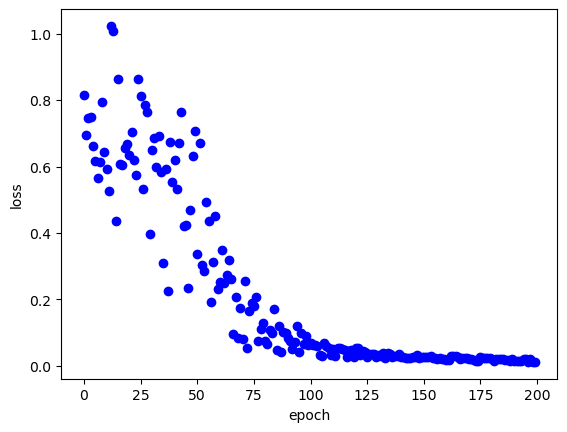

In [62]:
input_dim = 2
hidden_dim = 10
output_dim = 2
model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim),
                      nn.Sigmoid()
                      )
model = model.to(device)

loss_func = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.02, momentum=0.9, weight_decay=0.001)

loss_values = train(epochs=200)
plt.plot(loss_values, 'ob')
plt.ylabel('loss')
plt.xlabel('epoch');

There are also more complex optimizers, such as the [Adam optimizer](https://arxiv.org/pdf/1412.6980.pdf) designed by Diederik Kingma and Jimmy Ba.  It uses a variety of techniques like adaptive learning rates and momentum to provide competitive performance.  To use it in Keras, call it as

epochs: 0	loss: 0.47724807
epochs: 10	loss: 0.51024973
epochs: 20	loss: 0.57486963
epochs: 30	loss: 0.5440524
epochs: 40	loss: 0.69189847
epochs: 50	loss: 0.53942704
epochs: 60	loss: 0.17670067
epochs: 70	loss: 0.1291801
epochs: 80	loss: 0.06457415
epochs: 90	loss: 0.022609524
epochs: 100	loss: 0.029967459
epochs: 110	loss: 0.012055597
epochs: 120	loss: 0.009663388
epochs: 130	loss: 0.018539408
epochs: 140	loss: 0.009192569
epochs: 150	loss: 0.004859833
epochs: 160	loss: 0.010626556
epochs: 170	loss: 0.0060461615
epochs: 180	loss: 0.003236392
epochs: 190	loss: 0.008387745


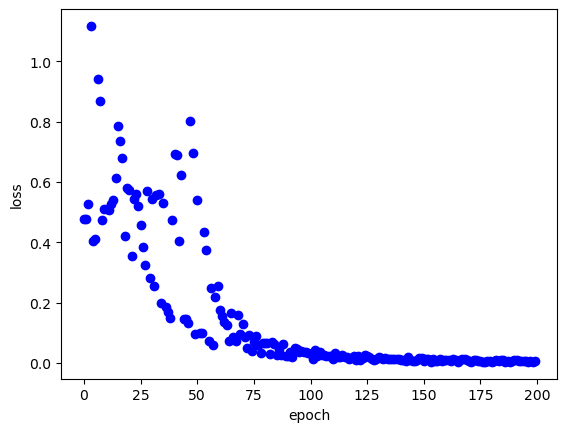

In [79]:
input_dim = 2
hidden_dim = 10
output_dim = 2
model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim),
                      nn.Sigmoid()
                      )
model = model.to(device)

loss_func = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=0)

loss_values = train(epochs=200)
plt.plot(loss_values, 'ob')
plt.ylabel('loss')
plt.xlabel('epoch');

It has default parameters that empirically work well on a wide class of problems.

## More Complex Problems

Now let's consider a slightly more difficult problem for neural networks:

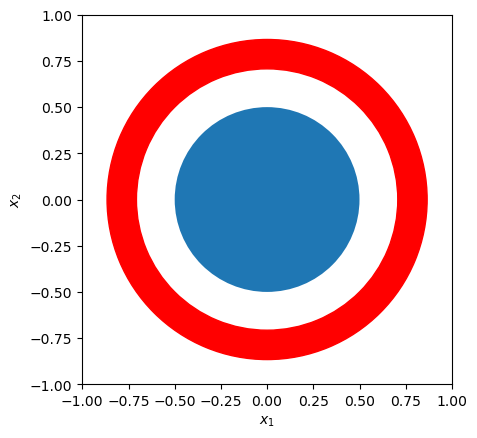

In [80]:
r1 = 0.5
r2 = np.sqrt(2*r1**2)
r3 = np.sqrt(r1**2 + r2**2)

fig = plt.figure()
ax = fig.add_subplot(111)

circle = plt.Circle((0, 0), r1)
annulus = matplotlib.patches.Wedge((0, 0), r3, 0, 360, width=r3-r2, color='r')
ax.add_artist(circle)
ax.add_artist(annulus)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', 'box');

By itself this is a relatively easy problem - if we convert to polar coordinates, we can just threshold based on the radius and have a very simple classifier that achieves 100% accuracy.  However, if we use the raw $x_1$ and $x_2$ inputs to a neural network, that information must be learned by the network.  The network must be able to construct a closed region in the plane, which requires more complexity than was necessary for XOR.

For training a network we need specific inputs, so we will get 500 points from the circle and 500 from the annulus with their associated class labels:

In [81]:
X_circle = []
y_circle = []
for i in range(150):
    # Circle
    vec = np.random.uniform(-1, 1, 2)
    while np.linalg.norm(vec) > r1:
        vec = np.random.uniform(-1, 1, 2)
    X_circle.append(vec)
    y_circle.append(0)
        
    # Annulus
    vec = np.random.uniform(-1, 1, 2)
    while np.linalg.norm(vec) < r2 or np.linalg.norm(vec) > r3:
        vec = np.random.uniform(-1, 1, 2)
    X_circle.append(vec)
    y_circle.append(1)
    
X_circle = np.array(X_circle)
X_circle = X_circle.astype('float32')
y_circle = np.array(y_circle)

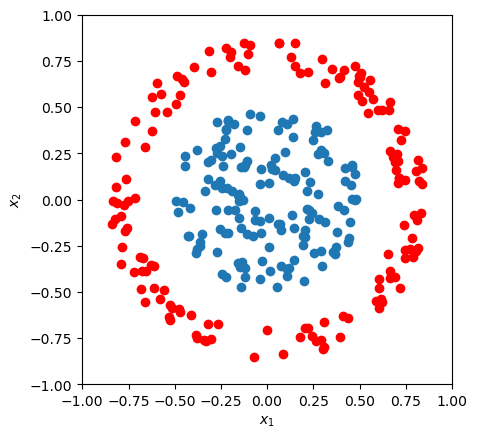

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_circle[y_circle==0, 0], X_circle[y_circle==0, 1])
ax.scatter(X_circle[y_circle==1, 0], X_circle[y_circle==1, 1], c='r')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', 'box');

In [83]:
X_circle = torch.tensor(X_circle, 
                        dtype=torch.float32, 
                        requires_grad=False, 
                        device=device)

In [84]:
Y_circle = torch.tensor(y_circle, 
                        dtype=torch.int64, 
                        requires_grad=False,
                        device=device)#.view(-1,1)

Y_circle_one_hot = F.one_hot(Y_circle)
Y_circle_one_hot = Y_circle_one_hot.type(torch.FloatTensor)

Let's train a simple network on this dataset:

In [85]:
def train(X, Y, epochs=50) :
    # if you would like to use tensorboard:
    #from torch.utils.tensorboard import SummaryWriter
    #writer = SummaryWriter()
    loss_values = []
    steps_per_epoch = X.size(0)
    for epoch in range(epochs):
        for j in range(steps_per_epoch):
            data_point = np.random.randint(X.size(0))
            x_var = Variable(X[data_point], requires_grad=False)
            y_var = Variable(Y[data_point], requires_grad=False)
            optimizer.zero_grad()
            y_hat = model(x_var)
            loss = loss_func.forward(y_hat, y_var)
            #writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
        loss_values.append(loss.data.cpu().numpy())
        if epoch % 10 == 0 :
            print("epochs: " + str(epoch) + "\tloss: " + str(loss.data.cpu().numpy()))
    return loss_values

epochs: 0	loss: 0.44262397
epochs: 10	loss: 0.18915218
epochs: 20	loss: 1.1026866e-06
epochs: 30	loss: 0.01198441
epochs: 40	loss: 0.000300065
epochs: 50	loss: 0.0
epochs: 60	loss: 0.0014190604
epochs: 70	loss: 0.0
epochs: 80	loss: 0.00227983
epochs: 90	loss: 0.0


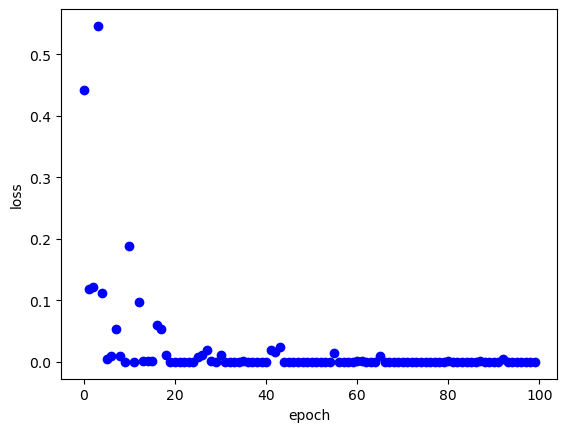

In [90]:
input_dim = 2
hidden_dim = 6
output_dim = 2
model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim),
                      nn.Sigmoid()
                      )
model = model.to(device)

loss_func = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=0.0)

loss_values = train(X_circle, Y_circle_one_hot, epochs=100)
plt.plot(loss_values, 'ob')
plt.ylabel('loss')
plt.xlabel('epoch');

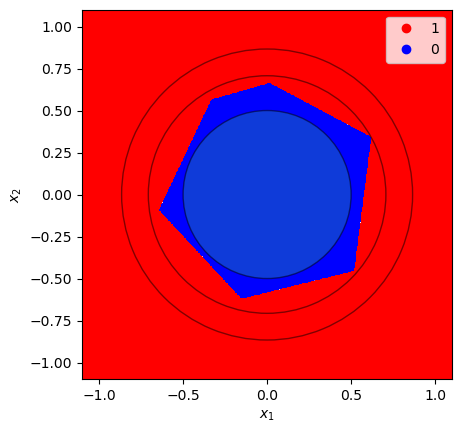

In [91]:
plot_circles_network(model, two_outputs=True)

## Comments

1. Some of the intuition from these small, two-input networks may not carry over in expected ways to higher dimensional problems.  Unfortunately, building intuition for those more complex problems is typically difficult due to the limited ability to analyze high dimensional networks.
2. Until relatively recently, one of the best methods for hyperparameter selection with neural networks was random search.  More sophisticated methods exist now, but without insight into the dataset it can be difficult to determine how to structure network architecture and training process.
